klue/bert-base 모델 사용

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -s /content/drive/MyDrive/ /gdrive

In [3]:
!cp -r /gdrive/aicon/aicon_retrailer data/

In [4]:
!pip install transformers datasets

     |████████████████████████████████| 2.6 MB 5.2 MB/s 
     |████████████████████████████████| 264 kB 47.4 MB/s 
     |████████████████████████████████| 3.3 MB 45.6 MB/s 
     |████████████████████████████████| 895 kB 48.4 MB/s 
     |████████████████████████████████| 636 kB 58.7 MB/s 
     |████████████████████████████████| 118 kB 53.1 MB/s 
     |████████████████████████████████| 243 kB 58.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import os
import sys
import warnings
import re

import numpy as np
import pandas as pd

import datasets
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

#from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

import seaborn as sns

#import optuna
#from ray import tune

warnings.filterwarnings(action='ignore')

In [6]:
train = pd.read_csv("./data/train/train.csv")
valid = pd.read_csv("./data/val/val.csv")

In [7]:
test = pd.read_csv("./data/test/test.csv")

In [8]:
dataset = pd.concat([train, valid], join='inner')

In [9]:
map_dict = {'AS_날짜_요청': 0,'AS_날짜_질문': 1,'AS_방법_요청': 2,'AS_방법_질문': 3,'AS_비용_요청': 4,'AS_비용_질문': 5,
                        'AS_시간_질문': 6,'AS_일반_질문': 7,'결제_방식_질문': 8,'결제_수단_질문': 9,'결제_시기_질문': 10,'결제_영수증_질문': 11,
                        '결제_오류_질문': 12,'결제_일반_질문': 13,'결제_일반_확인': 14,'결제_재결제_질문': 15,'결제_추가_질문': 16,
                        '결제_취소_질문': 17,'결제_할인_질문': 18,'교환|반품|환불_방법_요청': 19,'교환|반품|환불_방법_질문': 20,
                        '교환|반품|환불_방법_확인': 21,'교환|반품|환불_비용_질문': 22,'교환|반품|환불_시간_요청': 23,
                        '교환|반품|환불_시간_질문': 24,'교환|반품|환불_일반_요청': 25,'교환|반품|환불_일반_질문': 26,
                        '교환|반품|환불_일반_확인': 27,'구매_예약_요청': 28,'구매_예약_질문': 29,'구매_제품_요청': 30,'구매_제품_질문': 31,
                        '매장_이용_요청': 32,'매장_이용_질문': 33,'매장_정보_질문': 34,'멤버십_사용_질문': 35,'멤버십_적립_질문': 36,
                        '배송_날짜_요청': 37,'배송_날짜_질문': 38,'배송_날짜_확인': 39,'배송_방법_요청': 40,'배송_방법_질문': 41,
                        '배송_방법_확인': 42,'배송_비용_질문': 43,'배송_오류_질문': 44,'배송_오류_확인': 45,'배송_일반_요청': 46,
                        '배송_일반_질문': 47,'배송_일반_확인': 48,'배송_지역_요청': 49,'배송_지역_질문': 50,'배송_택배사_질문': 51,
                        '부가서비스_날짜_요청': 52,'부가서비스_날짜_질문': 53,'부가서비스_방법_요청': 54,'부가서비스_방법_질문': 55,
                        '부가서비스_비용_요청': 56,'부가서비스_비용_질문': 57,'웹사이트_사용_질문': 58,'웹사이트_오류_질문': 59,
                        '제품_가격_비교': 60,'제품_가격_요청': 61,'제품_가격_질문': 62,'제품_가격_확인': 63,'제품_구성_요청': 64,
                        '제품_구성_질문': 65,'제품_구성_확인': 66,'제품_날짜_질문': 67,'제품_방법_요청': 68,'제품_방법_질문': 69,
                        '제품_방법_확인': 70,'제품_불량_요청': 71,'제품_불량_질문': 72,'제품_불량_확인': 73,'제품_소재_질문': 74,
                        '제품_시용_요청': 75,'제품_시용_질문': 76,'제품_용도_질문': 77,'제품_용도_확인': 78,'제품_원산지_질문': 79,
                        '제품_일반_비교': 80,'제품_일반_요청': 81,'제품_일반_질문': 82,'제품_일반_확인': 83,'제품_입고_요청': 84,
                        '제품_입고_질문': 85,'제품_재고_요청': 86,'제품_재고_질문': 87,'제품_재고_확인': 88,'제품_정보_비교': 89,
                        '제품_정보_요청': 90,'제품_정보_질문': 91,'제품_정보_확인': 92,'제품_추천_비교': 93,'제품_추천_요청': 94,
                        '제품_추천_질문': 95,'제품_추천_확인': 96,'제품_커스텀_요청': 97,'제품_커스텀_질문': 98,'제품_품질_비교': 99,
                        '제품_품질_요청': 100,'제품_품질_질문': 101,'제품_품질_확인': 102,'제품_호환_질문': 103,'제품_호환_확인': 104,
                        '포장_방식_요청': 105,'포장_방식_질문': 106,'포장_비용_질문': 107,'포장_일반_질문': 108,'행사_기간_질문': 109,
                        '행사_기간_확인': 110,'행사_날짜_질문': 111,'행사_유형_질문': 112,'행사_유형_확인': 113,'행사_일반_질문': 114,
                        '행사_일반_확인': 115,'행사_정보_요청': 116,'행사_정보_질문': 117}

In [10]:
def set_values(row, value):
    return value[row]

In [11]:
dataset['label'] = dataset['intent'].apply(set_values, args =(map_dict, ))

In [12]:
"""
def BalancingData(dataset, num_labels, drop_label, drop_rate, over_rate):
  counterFunc = dataset.apply(lambda x: True if x['label'] == drop_label else False , axis=1)
  num_rows = len(counterFunc[counterFunc == True].index)
  dropping = int(drop_rate * num_rows)
  dataset = dataset.drop(np.random.choice(dataset.index[dataset['label'].eq(drop_label)], dropping))

  for i in range(num_labels):
    if i == drop_label:
      pass
    else:
      df = dataset['label'] == i
      df = dataset[df]
      tmp = [df]*(over_rate-1)
      tmp.append(dataset)
      dataset = pd.concat(tmp)

  return dataset
"""  

"\ndef BalancingData(dataset, num_labels, drop_label, drop_rate, over_rate):\n  counterFunc = dataset.apply(lambda x: True if x['label'] == drop_label else False , axis=1)\n  num_rows = len(counterFunc[counterFunc == True].index)\n  dropping = int(drop_rate * num_rows)\n  dataset = dataset.drop(np.random.choice(dataset.index[dataset['label'].eq(drop_label)], dropping))\n\n  for i in range(num_labels):\n    if i == drop_label:\n      pass\n    else:\n      df = dataset['label'] == i\n      df = dataset[df]\n      tmp = [df]*(over_rate-1)\n      tmp.append(dataset)\n      dataset = pd.concat(tmp)\n\n  return dataset\n"

In [13]:
#dataset = BalancingData(train, 46, 0, 0.95, 6)

In [14]:
dataset.label.value_counts(sort=False)*100/len(dataset)

0      0.043492
1      0.300441
2      0.183573
3      0.658514
4      0.045360
         ...   
113    0.055232
114    1.678305
115    0.090986
116    0.031752
117    0.771647
Name: label, Length: 118, dtype: float64

In [15]:
dataset.label.value_counts(sort=False)

0       163
1      1126
2       688
3      2468
4       170
       ... 
113     207
114    6290
115     341
116     119
117    2892
Name: label, Length: 118, dtype: int64

In [16]:
dataset.label.value_counts(sort = True)

91     72999
38     54908
69     28061
103    24785
65     18246
       ...  
63        71
9         70
78        70
35        66
42        60
Name: label, Length: 118, dtype: int64

In [17]:
dataset.count()

conv_num    374783
intent      374783
question    374783
answer      374783
label       374783
dtype: int64

In [18]:
dataset.head()

,conv_num,intent,question,answer,label
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0


In [19]:
dataset['intent'].fillna('NAN', inplace=True)
dataset['question'].fillna('NAN', inplace=True)
dataset['answer'].fillna('NAN', inplace=True)

In [20]:
dataset['data'] = dataset['question'] + dataset['answer']
test['data'] = test['question'] + test['answer']

In [21]:
dataset.head()

,conv_num,intent,question,answer,label,data
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인..."
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다."
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실..."
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어..."
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다."


In [22]:
test.head()

,conv_num,question,answer,data
0,9710,노트북 수리 맡기면 바로 받을 수 있나요?,오늘 바로 받으실 수 있어요.,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,9711,노트북 수리 맡기면 오늘 받을 수 있어요?,"네, 오늘 받으실 수 있습니다.","노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,9728,오늘 노트북 수리 들어가면 내일 찾을 수 있죠?,"네, 내일 찾아가세요.","오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,9737,어제 수리맡긴 노트북 내일 찾을 수 있습니까?,"네, 내일 찾으러 오시면 됩니다.","어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,11050,TV AS 이번주 안에 가능한가요?,"네, 이번주까지 해드리겠습니다.","TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


In [23]:
"""
# cleansing 함수 

def cleansing(text):
    text = re.sub('([ㄱ-ㅎㅏ-ㅣ]+)', ' ', str(text)) # 자음, 모음 제거
    text = re.sub('[^가-히\s]', ' ', str(text))
    text = re.sub('[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', ' ', str(text)) #remove punctuation
    text = re.sub('\d+',' ', str(text))# remove number
    text = text.lower() #lower case
    #text = re.sub('\s+', ' ', str(text)) #remove extra space
    #text = re.sub('<[^>]+>','', str(text)) #remove Html tags
    #text = re.sub('\s+', ' ', str(text)) #remove spaces
    #text = re.sub("^\s+", '', str(text)) #remove space from start
    #text = re.sub('\s+$', '', str(text)) #remove space from the end
    text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]", " ", str(text))
    text = re.sub('[-=+,#:;//●○<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》()]', ' ', str(text))
    #text = re.sub('/\r\n|\r|\n/', ' ', str(text))
    return text
"""    

'\n# cleansing 함수 \n\ndef cleansing(text):\n    text = re.sub(\'([ㄱ-ㅎㅏ-ㅣ]+)\', \' \', str(text)) # 자음, 모음 제거\n    text = re.sub(\'[^가-히\\s]\', \' \', str(text))\n    text = re.sub(\'[@%\\*=()/~#&\\+á?Ã¡\\-\\|\\.\\:\\;\\!\\-\\,\\_\\~\\$\'"]\', \' \', str(text)) #remove punctuation\n    text = re.sub(\'\\d+\',\' \', str(text))# remove number\n    text = text.lower() #lower case\n    #text = re.sub(\'\\s+\', \' \', str(text)) #remove extra space\n    #text = re.sub(\'<[^>]+>\',\'\', str(text)) #remove Html tags\n    #text = re.sub(\'\\s+\', \' \', str(text)) #remove spaces\n    #text = re.sub("^\\s+", \'\', str(text)) #remove space from start\n    #text = re.sub(\'\\s+$\', \'\', str(text)) #remove space from the end\n    text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]", " ", str(text))\n    text = re.sub(\'[-=+,#:;//●○<>▲\\?:^$.☆!★()Ⅰ@*"※~>`\'…》()]\', \' \', str(text))\n    #text = re.sub(\'/\r\n|\r|\n/\', \' \', str(text))\n    return text\n'

In [24]:
#dataset['data'] = dataset['data'].map(lambda x: cleansing(x))
#test['data'] = test['data'].map(lambda x: cleansing(x))

In [25]:
dataset=dataset[['data','label']]
test=test[['data']]

In [26]:
dataset.head()

,data,label
0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인...",0
1,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다.",0
2,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실...",0
3,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어...",0
4,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다.",0


In [27]:
test.head()

,data
0,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,"노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,"오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,"어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,"TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


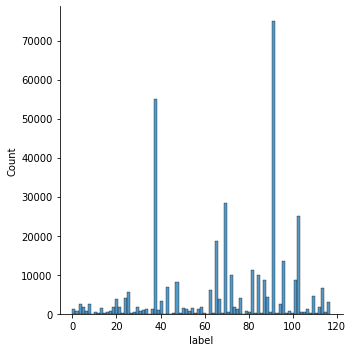

In [28]:
sns.displot(dataset.label)

In [29]:
model_checkpoint = "klue/roberta-large"
batch_size = 32
RANDOM_SEED = 42

In [30]:
target = dataset['label']
dataset_train, dataset_val = train_test_split(dataset,test_size = 0.2, stratify = target, random_state = RANDOM_SEED)

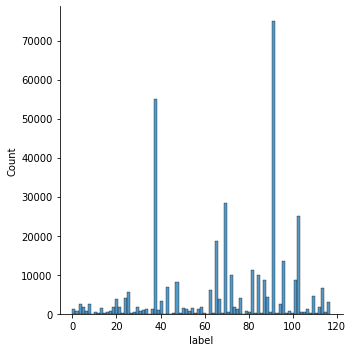

In [31]:
sns.displot(dataset.label)

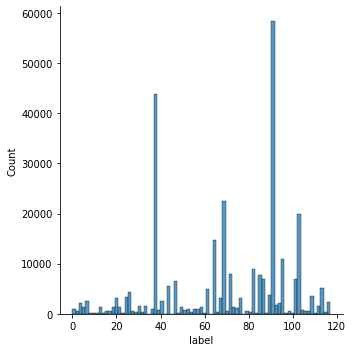

In [32]:
sns.displot(dataset_train.label)

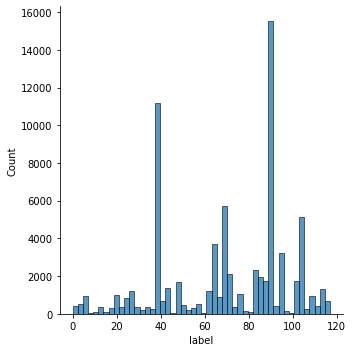

In [33]:
sns.displot(dataset_val.label)

In [34]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [35]:
"""
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_key, label_key, bert_tokenizer):
        
        self.sentences = [ bert_tokenizer(i,truncation=True,return_token_type_ids=False) for i in dataset[sent_key] ]
        
        if not label_key == None:
            self.mode = "train"
        else:
            self.mode = "test"
            
        if self.mode == "train":
            self.labels = [np.int64(i) for i in dataset[label_key]]
        else:
            self.labels = [np.int64(0) for i in dataset[sent_key]]

    def __getitem__(self, i):
        if self.mode == "train":
            self.sentences[i]["label"] = self.labels[i]
            return self.sentences[i]

        else:
            return self.sentences[i]

    def __len__(self):
        return (len(self.labels))
"""

'\nclass BERTDataset(Dataset):\n    def __init__(self, dataset, sent_key, label_key, bert_tokenizer):\n        \n        self.sentences = [ bert_tokenizer(i,truncation=True,return_token_type_ids=False) for i in dataset[sent_key] ]\n        \n        if not label_key == None:\n            self.mode = "train"\n        else:\n            self.mode = "test"\n            \n        if self.mode == "train":\n            self.labels = [np.int64(i) for i in dataset[label_key]]\n        else:\n            self.labels = [np.int64(0) for i in dataset[sent_key]]\n\n    def __getitem__(self, i):\n        if self.mode == "train":\n            self.sentences[i]["label"] = self.labels[i]\n            return self.sentences[i]\n\n        else:\n            return self.sentences[i]\n\n    def __len__(self):\n        return (len(self.labels))\n'

In [36]:
"""
data_train = BERTDataset(dataset_train, "data", "label", tokenizer)
data_val = BERTDataset(dataset_val, "data", "label", tokenizer)
data_test = BERTDataset(test, "data", None, tokenizer)
"""

'\ndata_train = BERTDataset(dataset_train, "data", "label", tokenizer)\ndata_val = BERTDataset(dataset_val, "data", "label", tokenizer)\ndata_test = BERTDataset(test, "data", None, tokenizer)\n'

In [37]:
def tokenized_dataset(dataset, tokenizer):
  tokenized_sentences = tokenizer(
      list(dataset['data']),
      return_tensors="pt",
      padding=True,
      truncation=True
      )
  return tokenized_sentences

In [38]:
# Dataset 구성.
class ROBERTA_Dataset(Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
    def get_classes(self):
        return self.labels

In [39]:
submission = pd.read_csv('./data/sample_submission.csv')

In [40]:
submission.head()

,conv_num,intent
0,9710,카테고리_채우기
1,9711,카테고리_채우기
2,9728,카테고리_채우기
3,9737,카테고리_채우기
4,11050,카테고리_채우기


In [41]:
submission['label'] = submission['intent']

In [42]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,카테고리_채우기
1,9711,카테고리_채우기,카테고리_채우기
2,9728,카테고리_채우기,카테고리_채우기
3,9737,카테고리_채우기,카테고리_채우기
4,11050,카테고리_채우기,카테고리_채우기


In [43]:
submission.loc[submission.label == '카테고리_채우기', 'label'] = -1

In [44]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,-1
1,9711,카테고리_채우기,-1
2,9728,카테고리_채우기,-1
3,9737,카테고리_채우기,-1
4,11050,카테고리_채우기,-1


In [45]:
train_label=dataset_train['label'].values
val_label=dataset_val['label'].values
test_label=submission['label'].values

tokenized_train = tokenized_dataset(dataset_train, tokenizer)
tokenized_val = tokenized_dataset(dataset_val, tokenizer)
tokenized_test = tokenized_dataset(test, tokenizer)

data_train = ROBERTA_Dataset(tokenized_train, train_label)
data_val = ROBERTA_Dataset(tokenized_val, val_label)
data_test = ROBERTA_Dataset(tokenized_test, test_label)

In [46]:
import gc
gc.collect()

50

In [47]:
num_labels = 118
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifi

In [48]:
metric = load_metric("glue", "mnli")

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [49]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [50]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [51]:
"""
metric_name = "eval_f1_macro"

args = TrainingArguments(
    "saved",
    evaluation_strategy="steps",
    #save_steps = 2500,
    #eval_steps = 2500, 
    #logging_steps = 2500, 
    learning_rate=2e-05,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    seed = RANDOM_SEED
)
"""

'\nmetric_name = "eval_f1_macro"\n\nargs = TrainingArguments(\n    "saved",\n    evaluation_strategy="steps",\n    #save_steps = 2500,\n    #eval_steps = 2500, \n    #logging_steps = 2500, \n    learning_rate=2e-05,\n    per_device_train_batch_size=batch_size,\n    per_device_eval_batch_size=batch_size,\n    num_train_epochs=2,\n    weight_decay=0.01,\n    load_best_model_at_end=True,\n    metric_for_best_model=metric_name,\n    greater_is_better=True,\n    seed = RANDOM_SEED\n)\n'

In [52]:
"""
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=data_train,
    eval_dataset=data_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
"""

'\ntrainer = Trainer(\n    model_init=model_init,\n    args=args,\n    train_dataset=data_train,\n    eval_dataset=data_val,\n    tokenizer=tokenizer,\n    compute_metrics=compute_metrics\n)\n'

시간 관계상 2번만 search를 진행했습니다.  
n_trials를 조절하여 grid search를 하는 횟수를 조절할 수 있습니다.


In [53]:
#best_run = trainer.hyperparameter_search(n_trials=1, direction="maximize")

In [54]:
#best_run

In [55]:
metric_name = "accuracy"

args = TrainingArguments(
    "saved",
    evaluation_strategy="steps",
    save_steps = 2500,
    eval_steps = 2500, 
    logging_steps = 2500, 
    learning_rate=2e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    seed = 42
)

In [56]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=data_train,
    eval_dataset=data_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file https://huggingface.co/klue/roberta-large/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/571e05a2160c18c93365862223c4dae92bbd1b41464a4bd5f372ad703dba6097.0818b4c76f4fcde0cdfae1ed1ae15072dd22eb48dd4832dec6c1193b6e62247a
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABE

In [ ]:
trainer.train()

loading configuration file https://huggingface.co/klue/roberta-large/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/571e05a2160c18c93365862223c4dae92bbd1b41464a4bd5f372ad703dba6097.0818b4c76f4fcde0cdfae1ed1ae15072dd22eb48dd4832dec6c1193b6e62247a
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABE

Step,Training Loss,Validation Loss,Accuracy
2500,1.749700,1.335695,0.647238
5000,1.318100,1.246068,0.649079


***** Running Evaluation *****
  Num examples = 74957
  Batch size = 8
Saving model checkpoint to saved/checkpoint-2500
Configuration saved in saved/checkpoint-2500/config.json
Model weights saved in saved/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in saved/checkpoint-2500/tokenizer_config.json
Special tokens file saved in saved/checkpoint-2500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 74957
  Batch size = 8
Saving model checkpoint to saved/checkpoint-5000
Configuration saved in saved/checkpoint-5000/config.json
Model weights saved in saved/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in saved/checkpoint-5000/tokenizer_config.json
Special tokens file saved in saved/checkpoint-5000/special_tokens_map.json


In [ ]:
trainer.evaluate()

In [ ]:
pred = trainer.predict(data_test)
pred = pred[0]
pred

In [ ]:
np.save("/gdrive/dacon_climate/npy/pred5.npy", pred)

In [ ]:
pred = np.argmax(pred,1)
#submission = pd.read_csv('./data/sample_submission.csv')
submission['label'] = pred
submission.to_csv("/gdrive/dacon_climate/result/klue_bert_base_trainer_5.csv",index=False)

참고문헌  
transformers 공식문서 How to fine-tune a model on text classification
https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb  

